# Test multitaper spectral estimation

In [25]:
# Import modules
from os.path import join
from obspy import read, UTCDateTime
from numpy import amax, abs, sqrt
from pandas import DataFrame, Timedelta, Timestamp
from matplotlib.pyplot import subplots

from utils_basic import ROOTDIR
from utils_cc import get_timewin_from_template_name
from utils_preproc import read_and_process_windowed_waveforms
from utils_snuffler import read_normal_markers
from utils_spec import get_data_spectrum, get_data_psd, get_filter_response

from multitaper import MTSpec

In [26]:
# Inputs
## Time windows and stations
station = "B04"
tempname = "BeatB16-08-06-34"
phase = "X"

begin_read = -0.15
end_read = 0.25

## Parameters for the multitaper analysis
nw1 = 2
nw2 = 4

## Filtering paramgters
freqmin = 10.0
freqmax = 450.0

## Plotting parameters
linewidth_wf = 1.0
linewidth_psd = 1.5

freqmin_plot = 10.0
freqmax_plot = 450.0

## Scale factors for plotting the waveforms and PSDs
scale_wf = 1.05
scale_psd = 3.0

psdmin = 1e-2

In [27]:
# Read the snuffler pick file
timewin = get_timewin_from_template_name(tempname)
pickdf = read_normal_markers(join(ROOTDIR, timewin, f"{phase.lower()}picks_{tempname}.dat"))

In [28]:
# Read and process the data
stream = read_and_process_windowed_waveforms(pickdf, freqmin, freqmax, begin=begin_read, end=end_read, stations=[station])

B04


In [29]:
# Compute the spectra

## Get the traces
trace_z = stream.select(station=station, component="Z")[0]
trace_1 = stream.select(station=station, component="1")[0]
trace_2 = stream.select(station=station, component="2")[0]

data_z = trace_z.data
data_1 = trace_1.data
data_2 = trace_2.data

samprat = trace_z.stats.sampling_rate
sampint = trace_z.stats.delta
timeax = trace_z.times()+begin_read

## Compute the spectra using the periodogram
freqax_per, psd_per_z = get_data_psd(data_z, samprat)
freqax_per, psd_per_1 = get_data_psd(data_1, samprat)
freqax_per, psd_per_2 = get_data_psd(data_2, samprat)

## Compute the spectra using the multitaper method
mtspec1_z = MTSpec(data_z, nw=nw1, dt=sampint)
mtspec1_1 = MTSpec(data_1, nw=nw1, dt=sampint)
mtspec1_2 = MTSpec(data_2, nw=nw1, dt=sampint)

freqax_mt, psd1_mt_z = mtspec1_z.rspec()
_, psd1_mt_1 = mtspec1_1.rspec()
_, psd1_mt_2 = mtspec1_2.rspec()

confint1_z = mtspec1_z.jackspec()
confint1_1 = mtspec1_1.jackspec()
confint1_2 = mtspec1_2.jackspec()

_, confint1_z = mtspec1_z.rspec(confint1_z)
_, confint1_1 = mtspec1_1.rspec(confint1_1)
_, confint1_2 = mtspec1_2.rspec(confint1_2)

mtspec2_z = MTSpec(data_z, nw=nw2, dt=sampint)
mtspec2_1 = MTSpec(data_1, nw=nw2, dt=sampint)
mtspec2_2 = MTSpec(data_2, nw=nw2, dt=sampint)

_, psd2_mt_z = mtspec2_z.rspec()
_, psd2_mt_1 = mtspec2_1.rspec()
_, psd2_mt_2 = mtspec2_2.rspec()

confint2_z = mtspec2_z.jackspec()
confint2_1 = mtspec2_1.jackspec()
confint2_2 = mtspec2_2.jackspec()

_, confint2_z = mtspec2_z.rspec(confint2_z)
_, confint2_1 = mtspec2_1.rspec(confint2_1)
_, confint2_2 = mtspec2_2.rspec(confint2_2)


Saved the figure to /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-08-00-00/multitaper_compare_BeatB16-08-06-34_B04.png


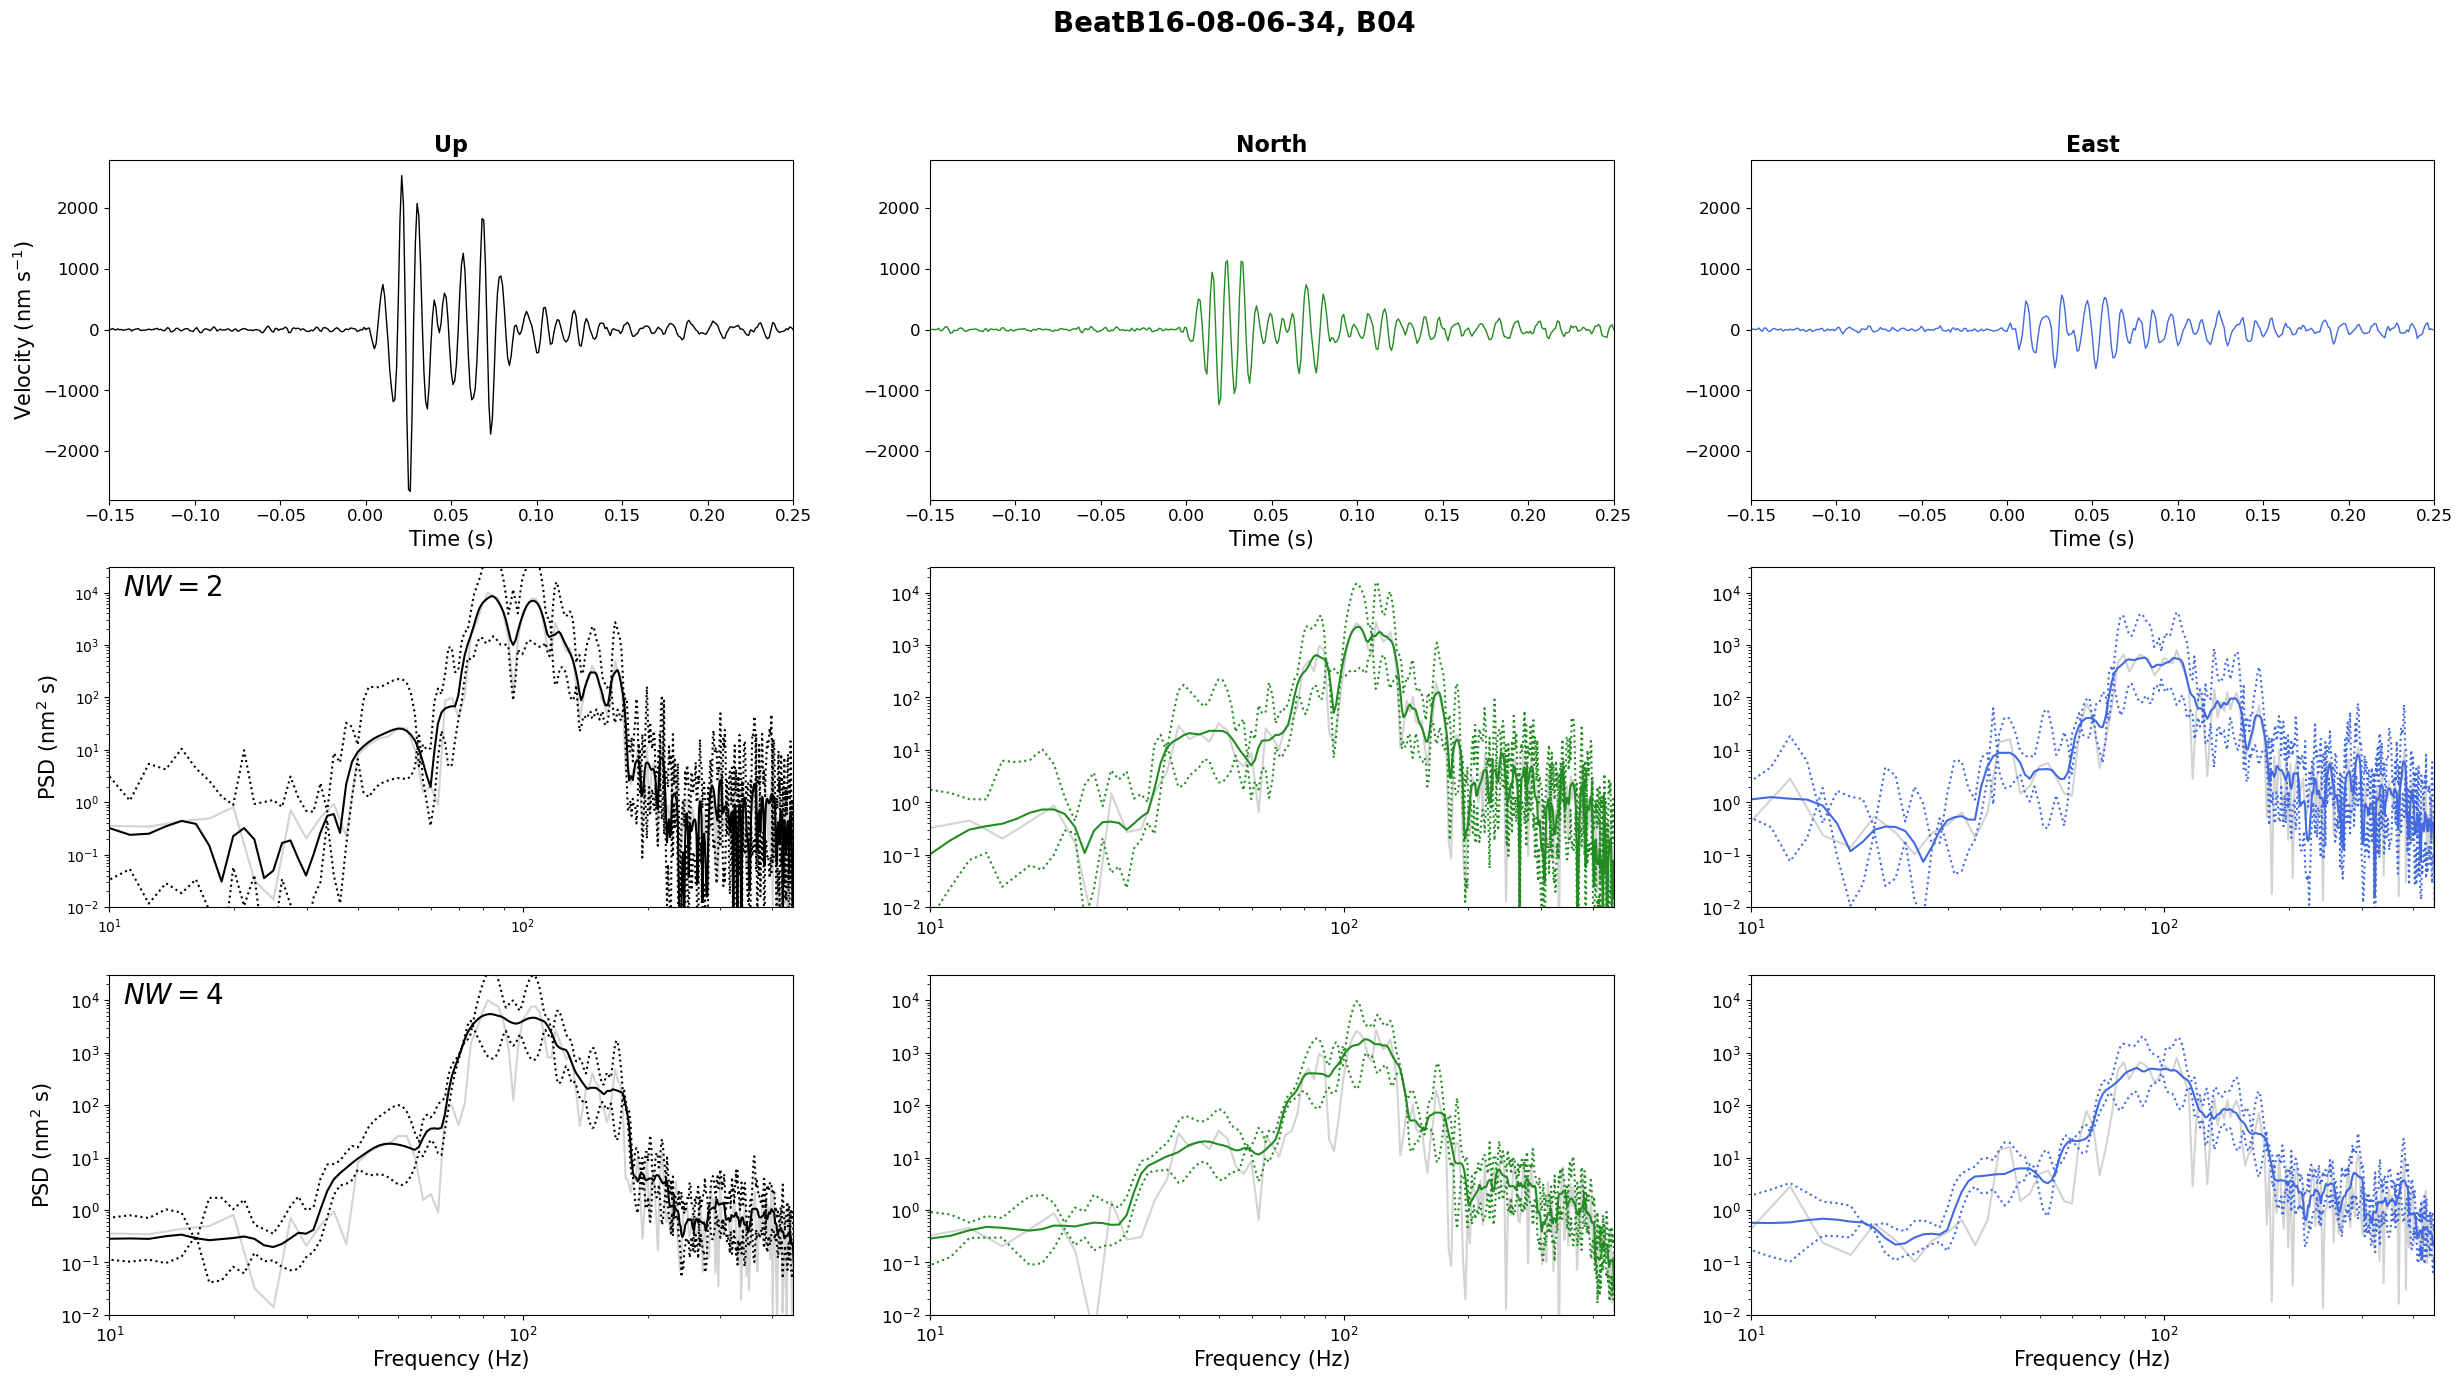

In [30]:
# Plot the comparison between the periodogram and the multitaper method

## Plot the waveforms
fig, axes = subplots(3, 3, figsize=(30, 15))

velmax = amax([amax(abs(data_z)), amax(abs(data_1)), amax(abs(data_2))]) * scale_wf

axes[0, 0].plot(timeax, data_z, color="black", linewidth=linewidth_wf)
axes[0, 0].set_title("Up", fontsize=16, fontweight="bold")
axes[0, 0].set_xlim(begin_read, end_read)
axes[0, 0].set_ylim(-velmax, velmax)
axes[0, 0].set_xlabel("Time (s)", fontsize=15)
axes[0, 0].set_ylabel("Velocity (nm s$^{-1}$)", fontsize=15)

for label in axes[0, 0].get_xticklabels():
    label.set_fontsize(12)

for label in axes[0, 0].get_yticklabels():
    label.set_fontsize(12)

axes[0, 1].plot(timeax, data_1, color="forestgreen", linewidth=linewidth_wf)
axes[0, 1].set_title("North", fontsize=16, fontweight="bold")
axes[0, 1].set_xlim(begin_read, end_read)
axes[0, 1].set_ylim(-velmax, velmax)
axes[0, 1].set_xlabel("Time (s)", fontsize=15)

for label in axes[0, 1].get_xticklabels():
    label.set_fontsize(12)

for label in axes[0, 1].get_yticklabels():
    label.set_fontsize(12)

axes[0, 2].plot(timeax, data_2, color="royalblue", linewidth=linewidth_wf)
axes[0, 2].set_title("East", fontsize=16, fontweight="bold")
axes[0, 2].set_xlim(begin_read, end_read)
axes[0, 2].set_ylim(-velmax, velmax)
axes[0, 2].set_xlabel("Time (s)", fontsize=15)

for label in axes[0, 2].get_xticklabels():
    label.set_fontsize(12)

for label in axes[0, 2].get_yticklabels():
    label.set_fontsize(12)

## Plot the spectra
psdmax = amax([amax(psd_per_z), amax(psd_per_1), amax(psd_per_2)]) * scale_psd

### The first multitaper analysis
axes[1, 0].loglog(freqax_per, psd_per_z, color="lightgray", linewidth=linewidth_psd)
axes[1, 0].loglog(freqax_mt, psd1_mt_z, color="black", linewidth=linewidth_psd)
axes[1, 0].loglog(freqax_mt, confint1_z, color="black", linestyle=":", linewidth=linewidth_psd)
axes[1, 0].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 0].set_ylim(psdmin, psdmax)
# axes[1, 0].set_xlabel("Frequency (Hz)", fontsize=15)
axes[1, 0].set_ylabel("PSD (nm$^2$ s)", fontsize=15)

axes[1, 0].text(0.02, 0.98, f"$NW = {nw1}$", fontsize=20, fontweight="bold", transform=axes[1, 0].transAxes, va="top", ha="left")

for label in axes[0, 2].get_xticklabels():
    label.set_fontsize(12)

for label in axes[0, 2].get_yticklabels():
    label.set_fontsize(12)

axes[1, 1].loglog(freqax_per, psd_per_1, color="lightgray", linewidth=linewidth_psd)
axes[1, 1].loglog(freqax_mt, psd1_mt_1, color="forestgreen", linewidth=linewidth_psd)
axes[1, 1].loglog(freqax_mt, confint1_1, color="forestgreen", linestyle=":", linewidth=linewidth_psd)
axes[1, 1].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 1].set_ylim(psdmin, psdmax)
# axes[1, 1].set_xlabel("Frequency (Hz)", fontsize=15)

for label in axes[1, 1].get_xticklabels():
    label.set_fontsize(12)

for label in axes[1, 1].get_yticklabels():
    label.set_fontsize(12)

axes[1, 2].loglog(freqax_per, psd_per_2, color="lightgray", linewidth=linewidth_psd)
axes[1, 2].loglog(freqax_mt, psd1_mt_2, color="royalblue", linewidth=linewidth_psd)
axes[1, 2].loglog(freqax_mt, confint1_2, color="royalblue", linestyle=":", linewidth=linewidth_psd)
axes[1, 2].set_xlim(freqmin_plot, freqmax_plot)
axes[1, 2].set_ylim(psdmin, psdmax)
#axes[1, 2].set_xlabel("Frequency (Hz)", fontsize=15)

for label in axes[1, 2].get_xticklabels():
    label.set_fontsize(12)

for label in axes[1, 2].get_yticklabels():
    label.set_fontsize(12)

### The second multitaper analysis
axes[2, 0].loglog(freqax_per, psd_per_z, color="lightgray", linewidth=linewidth_psd)
axes[2, 0].loglog(freqax_mt, psd2_mt_z, color="black", linewidth=linewidth_psd)
axes[2, 0].loglog(freqax_mt, confint2_z, color="black", linestyle=":", linewidth=linewidth_psd)
axes[2, 0].set_xlim(freqmin_plot, freqmax_plot)
axes[2, 0].set_ylim(psdmin, psdmax)
axes[2, 0].set_xlabel("Frequency (Hz)", fontsize=15)
axes[2, 0].set_ylabel("PSD (nm$^2$ s)", fontsize=15)

axes[2, 0].text(0.02, 0.98, f"$NW = {nw2}$", fontsize=20, fontweight="bold", transform=axes[2, 0].transAxes, va="top", ha="left")

for label in axes[2, 0].get_xticklabels():
    label.set_fontsize(12)

for label in axes[2, 0].get_yticklabels():
    label.set_fontsize(12)

axes[2, 1].loglog(freqax_per, psd_per_1, color="lightgray", linewidth=linewidth_psd)
axes[2, 1].loglog(freqax_mt, psd2_mt_1, color="forestgreen", linewidth=linewidth_psd)
axes[2, 1].loglog(freqax_mt, confint2_1, color="forestgreen", linestyle=":", linewidth=linewidth_psd)
axes[2, 1].set_xlim(freqmin_plot, freqmax_plot)
axes[2, 1].set_ylim(psdmin, psdmax)
axes[2, 1].set_xlabel("Frequency (Hz)", fontsize=15)

for label in axes[2, 1].get_xticklabels():
    label.set_fontsize(12)

for label in axes[2, 1].get_yticklabels():
    label.set_fontsize(12)

axes[2, 2].loglog(freqax_per, psd_per_2, color="lightgray", linewidth=linewidth_psd)
axes[2, 2].loglog(freqax_mt, psd2_mt_2, color="royalblue", linewidth=linewidth_psd)
axes[2, 2].loglog(freqax_mt, confint2_2, color="royalblue", linestyle=":", linewidth=linewidth_psd)
axes[2, 2].set_xlim(freqmin_plot, freqmax_plot)
axes[2, 2].set_ylim(psdmin, psdmax)
axes[2, 2].set_xlabel("Frequency (Hz)", fontsize=15)

for label in axes[2, 2].get_xticklabels():
    label.set_fontsize(12)

for label in axes[2, 2].get_yticklabels():
    label.set_fontsize(12)
    
fig.suptitle(f"{tempname}, {station}", fontsize=20, fontweight="bold")

# Save the figure
fig.patch.set_alpha(0.0)

outpath = join(ROOTDIR, timewin, f"multitaper_compare_{tempname}_{station}.png")
fig.savefig(outpath, dpi=300)
print(f"Saved the figure to {outpath}")
